# Regression Loss Functions

In this notebook, we perform side by side comparison of the most common regression loss functions.

In [315]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense
from keras import backend as K
import functools
from scipy.stats import norm, laplace

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from matplotlib import rc, cm
plt.rcParams.update({'pdf.fonttype': 'truetype'})

## Generating a test data sample

In [294]:
x = np.linspace(-5, 5, 500)
y_base = np.sinc(x)
n = 0.5 * np.random.beta(2, 5, len(x))
n_out = 0.5 * np.random.choice(2, len(x), p=[0.8, 0.2]) * np.abs(np.random.randn(len(x)))
y = y_base + n + n_out - np.mean(n)

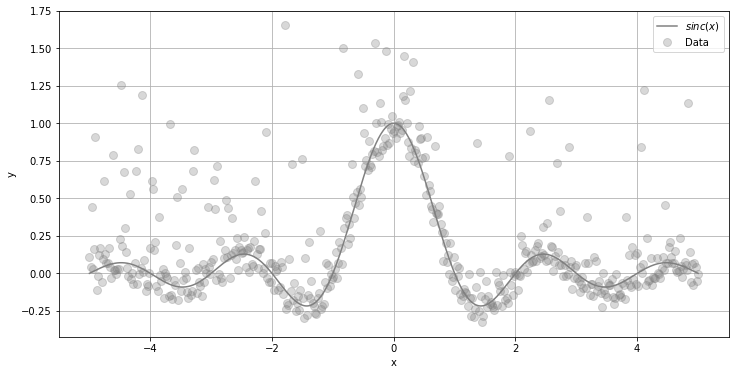

In [295]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(x, y_base, color='gray', label='$sinc(x)$')
ax.plot(x, y, marker='o', markersize=8, linestyle='None', alpha=0.3, color='gray', label='Data')
ax.grid(True)
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.savefig('data.pdf')

## Fitting and comparing models using different loss functions

In [301]:
def train_model(loss):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    model.compile(optimizer = 'adam',
              loss = loss)

    model.fit(np.atleast_2d(x).T, np.atleast_2d(y).T, epochs=512, verbose=0)
    
    return model

def pinball_loss(y_true, y_pred, tau):
    err = y_true - y_pred
    return K.mean(K.maximum(tau * err, (tau - 1) * err), axis=-1)

model_mse = train_model(tf.keras.losses.MeanSquaredError())
model_mae = train_model(tf.keras.losses.MeanAbsoluteError())
model_huber_1 = train_model(tf.keras.losses.Huber(delta=0.1))
model_huber_2 = train_model(tf.keras.losses.Huber(delta=10))
model_q_1 = train_model(functools.partial(pinball_loss, tau=0.2))
model_q_2 = train_model(functools.partial(pinball_loss, tau=0.8))

y_hat_mse = model_mse.predict(x)
y_hat_mae = model_mae.predict(x)
y_hat_huber_1 = model_huber_1.predict(x)
y_hat_huber_2 = model_huber_2.predict(x)
y_hat_q_1 = model_q_1.predict(x)
y_hat_q_2 = model_q_2.predict(x)

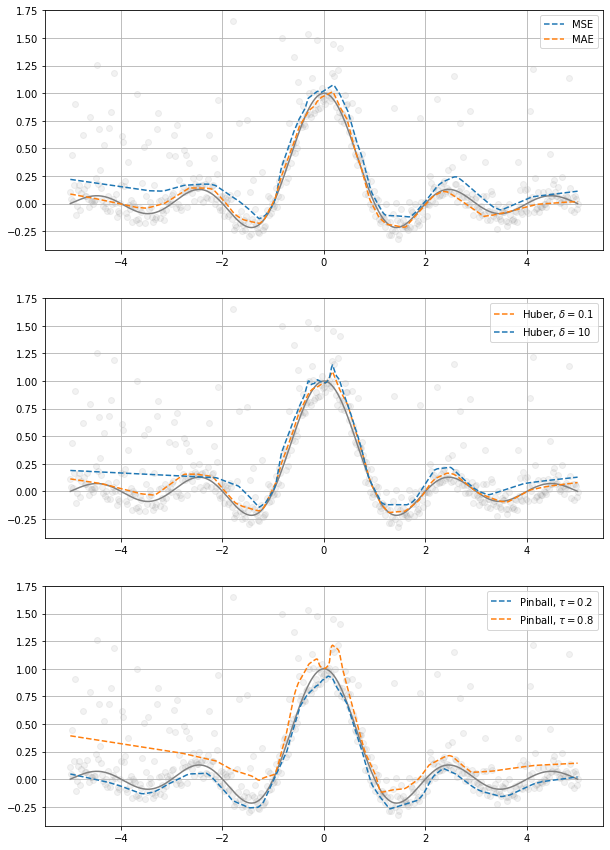

In [302]:
fix, ax = plt.subplots(3, 1, figsize=(10, 15))

for i in range(len(ax)):
    ax[i].scatter(x, y,  alpha=0.1, color='gray')
    ax[i].plot(x, y_base, c='gray')
    ax[i].grid(True)

ax[0].plot(x, y_hat_mse, c='C0', linestyle='--', label='MSE')
ax[0].plot(x, y_hat_mae, c='C1', linestyle='--', label='MAE')

ax[1].plot(x, y_hat_huber_1, c='C1', linestyle='--', label=r'Huber, $\delta=0.1$')
ax[1].plot(x, y_hat_huber_2, c='C0', linestyle='--', label=r'Huber, $\delta=10$')

ax[2].plot(x, y_hat_q_1, c='C0', linestyle='--', label=r'Pinball, $\tau=0.2$')
ax[2].plot(x, y_hat_q_2, c='C1', linestyle='--', label=r'Pinball, $\tau=0.8$')

for i in range(len(ax)):
    ax[i].legend()
    
plt.savefig('loss-fit.pdf')

## Visualizing the loss functions

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


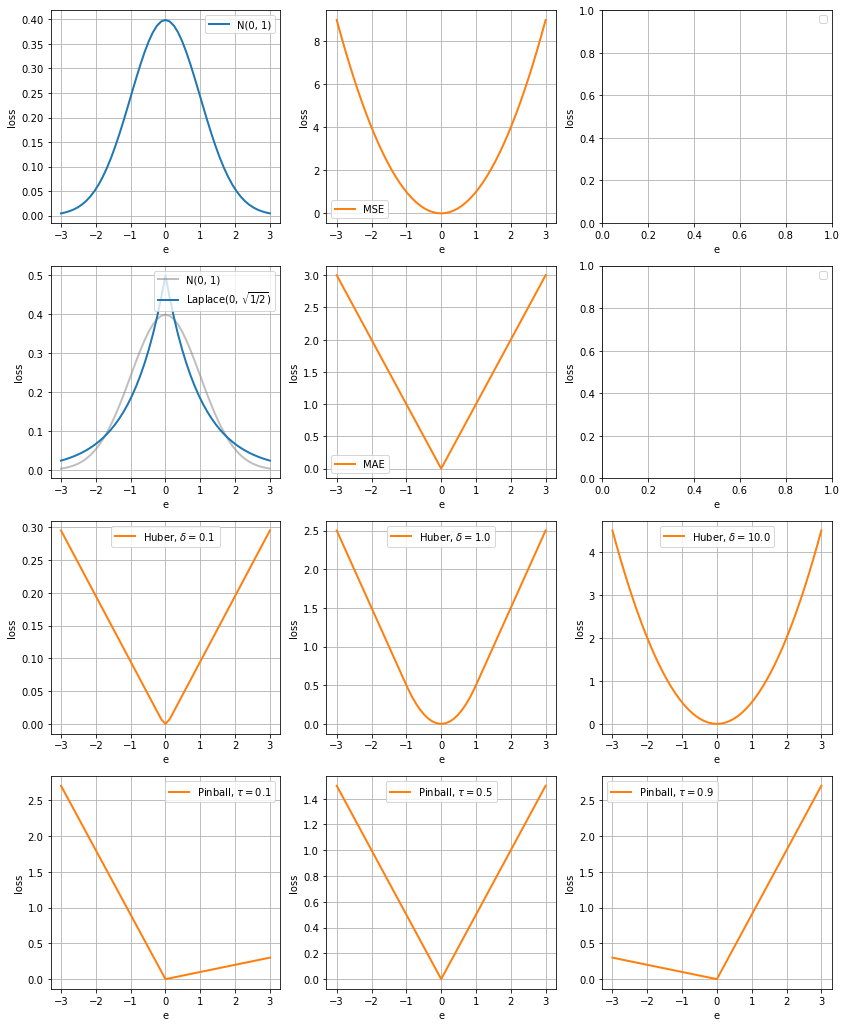

In [340]:
n = 51
y_true = np.zeros(n)
y_pred = np.linspace(-3, 3, n)

def calculate_loss(loss):
    return loss(np.atleast_2d(y_true).T, np.atleast_2d(y_pred).T).numpy()

mse = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)
mae = tf.keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.NONE)
huber_1 = tf.keras.losses.Huber(delta=0.1, reduction=tf.keras.losses.Reduction.NONE)
huber_2 = tf.keras.losses.Huber(delta=1.0, reduction=tf.keras.losses.Reduction.NONE)
huber_3 = tf.keras.losses.Huber(delta=10.0, reduction=tf.keras.losses.Reduction.NONE)
pinball_1 = functools.partial(pinball_loss, tau=0.1)
pinball_2 = functools.partial(pinball_loss, tau=0.5)
pinball_3 = functools.partial(pinball_loss, tau=0.9)


fix, ax = plt.subplots(4, 3, figsize=(14, 18))
dx = np.linspace(-3, 3, 51)
ax[0, 0].plot(dx, norm().pdf(dx), linewidth=2, label='N(0, 1)')
ax[0, 1].plot(y_true - y_pred, calculate_loss(mse), linewidth=2, label='MSE', c='C1')

ax[1, 0].plot(dx, norm().pdf(dx), linewidth=2, label='N(0, 1)', color='gray', alpha=0.5)
ax[1, 0].plot(dx, laplace().pdf(dx), linewidth=2, label=r'Laplace(0, $\sqrt{1/2}$)')
ax[1, 1].plot(y_true - y_pred, calculate_loss(mae), linewidth=2, c='C1', label='MAE')

ax[2, 0].plot(y_true - y_pred, calculate_loss(huber_1), linewidth=2, c='C1', label=r'Huber, $\delta=0.1$')
ax[2, 1].plot(y_true - y_pred, calculate_loss(huber_2), linewidth=2, c='C1', label=r'Huber, $\delta=1.0$')
ax[2, 2].plot(y_true - y_pred, calculate_loss(huber_3), linewidth=2, c='C1', label=r'Huber, $\delta=10.0$')

ax[3, 0].plot(y_true - y_pred, calculate_loss(pinball_1), linewidth=2, c='C1', label=r'Pinball, $\tau=0.1$')
ax[3, 1].plot(y_true - y_pred, calculate_loss(pinball_2), linewidth=2, c='C1', label=r'Pinball, $\tau=0.5$')
ax[3, 2].plot(y_true - y_pred, calculate_loss(pinball_3), linewidth=2, c='C1', label=r'Pinball, $\tau=0.9$')

for i in range(ax.shape[0]):
    for j in range(ax.shape[1]):
        ax[i, j].legend()
        ax[i, j].grid(True)
        ax[i, j].set_xlabel('e')
        ax[i, j].set_ylabel('loss')
    
plt.savefig('losses.pdf')